# Data imputation
[TOC]

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from mlens.visualization import pca_comp_plot
from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)

mean = [64.44, 0.34, 37.60, 0.51, 0.50, 7.06, 40.68, 602.52, 368.17, 2.5e3, 92.54, 72.09, 91.92, 7.45, 0.28, 0.02]
std = [15.05, 0.34*(1-0.34), 0.97, 0.51*(1-0.51), 0.50*(1-0.50), 3.53, 66.93, 158.36, 235.22, 6743.13, 7.00, 26.11, 8.24, 0.06, 0.28*(1-0.28), 0.02*(1-0.02)]

def fill_dataset(dataset, feature, filled_feature, save_path):
    filled_dataset = dataset.copy()
    filled_dataset[feature] = filled_feature
    filled_dataset.to_csv(save_path, index=None)
    return filled_dataset

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((32, 64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=64, random_state=seed)
    rf = RandomForestClassifier(n_estimators=64, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(n_estimators=64, random_state=seed)
    xgb = XGBClassifier(random_state=seed)        
    models = {'svm': svc, 
              'knn': knn, 
              'naive bayes': nb,
              'mlp': nn,
              'random forest': rf,
              'gradient boost': gb,
              'logistic': lr,
              'adaboost': ab,
              'xgboost': xgb, 
             }
    return models

def sensitivity_specificity(cm):
    return cm[1, 1] / np.sum(cm[1]), cm[0, 0] / np.sum(cm[0])

def get_severity(Prognosis):
    if Prognosis == 'MILD':
        return 0
    elif Prognosis == 'SEVERE':
        return 1

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    feature_importances = {}
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
        try:
            feature_importances.update({name: m.feature_importances_})
        except:
            print('no feature importances')
    print('done.')
    return feature_importances

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

def z_score_normalize(X, mean=mean, std=std):
    return (X - mean)/std

def z_score_denormalize(X, mean=mean, std=std):
    return (X * std) + mean

Using TensorFlow backend.
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

## Read data

In [2]:
train_data_path = './trainSet/trainSet.txt'
test_data_path = './testSet/testSet.txt'

In [3]:
train_dataset = pd.read_csv(train_data_path, sep=',')
train_dataset['severity'] = train_dataset['Prognosis'].map(get_severity)
test_dataset = pd.read_csv(test_data_path, sep=',')

feature = [
    'Age', 
    'Sex', 
    'Temp_C', 
    'Cough', 
    'DifficultyInBreathing', 
    'WBC', 
    'CRP',
    'Fibrinogen', 
    'LDH',
    'Ddimer', 
    'Ox_percentage',
    'PaO2', 
    'SaO2',
    'pH',
    'CardiovascularDisease',
    'RespiratoryFailure',
]

y = np.array(train_dataset['severity'])

## Imputation
### Impute testing dataset
- Filled NaN data using [method] based on concatenation of trainSet.txt & testSet.txt.
- There are columns filled with **NaN** so we need **concatenation** of trainSet.txt & testSet.txt, otherwise nothing meaningful imputation can be obtained.

In [4]:
concat_feature = pd.concat([test_dataset[feature], train_dataset[feature]])
test_dataset_len = len(test_dataset)
train_dataset_len = len(train_dataset)

In [5]:
X_incomplete = concat_feature
X_incomplete = np.array(X_incomplete)
X_incomplete = z_score_normalize(X_incomplete)

X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_5 = KNN(k=5).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

test_dataset_filled_knn_3 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_3[:test_dataset_len]), './csv/filled_testSet/filled_knn_3_testSet.txt')
test_dataset_filled_knn_5 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_6[:test_dataset_len]), './csv/filled_testSet/filled_knn_5_testSet.txt')
test_dataset_filled_knn_6 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_6[:test_dataset_len]), './csv/filled_testSet/filled_knn_6_testSet.txt')
test_dataset_filled_knn_9 = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_knn_9[:test_dataset_len]), './csv/filled_testSet/filled_knn_9_testSet.txt')
test_dataset_filled_softimpute = fill_dataset(test_dataset, feature, z_score_denormalize(X_filled_softimpute[:test_dataset_len]), './csv/filled_testSet/filled_softimpute_testSet.txt')

Imputing row 1/983 with 4 missing, elapsed time: 0.175
Imputing row 101/983 with 9 missing, elapsed time: 0.185
Imputing row 201/983 with 4 missing, elapsed time: 0.190
Imputing row 301/983 with 6 missing, elapsed time: 0.194
Imputing row 401/983 with 3 missing, elapsed time: 0.200
Imputing row 501/983 with 1 missing, elapsed time: 0.205
Imputing row 601/983 with 3 missing, elapsed time: 0.211
Imputing row 701/983 with 4 missing, elapsed time: 0.215
Imputing row 801/983 with 3 missing, elapsed time: 0.221
Imputing row 901/983 with 1 missing, elapsed time: 0.226
Imputing row 1/983 with 4 missing, elapsed time: 0.176
Imputing row 101/983 with 9 missing, elapsed time: 0.186
Imputing row 201/983 with 4 missing, elapsed time: 0.193
Imputing row 301/983 with 6 missing, elapsed time: 0.198
Imputing row 401/983 with 3 missing, elapsed time: 0.203
Imputing row 501/983 with 1 missing, elapsed time: 0.208
Imputing row 601/983 with 3 missing, elapsed time: 0.213
Imputing row 701/983 with 4 missing

[SoftImpute] Iter 56: observed MAE=0.023564 rank=15
[SoftImpute] Iter 57: observed MAE=0.023564 rank=15
[SoftImpute] Iter 58: observed MAE=0.023565 rank=15
[SoftImpute] Iter 59: observed MAE=0.023566 rank=15
[SoftImpute] Iter 60: observed MAE=0.023566 rank=15
[SoftImpute] Iter 61: observed MAE=0.023567 rank=15
[SoftImpute] Iter 62: observed MAE=0.023568 rank=15
[SoftImpute] Iter 63: observed MAE=0.023568 rank=15
[SoftImpute] Iter 64: observed MAE=0.023569 rank=15
[SoftImpute] Iter 65: observed MAE=0.023569 rank=15
[SoftImpute] Iter 66: observed MAE=0.023570 rank=15
[SoftImpute] Iter 67: observed MAE=0.023570 rank=15
[SoftImpute] Iter 68: observed MAE=0.023571 rank=15
[SoftImpute] Iter 69: observed MAE=0.023572 rank=15
[SoftImpute] Iter 70: observed MAE=0.023572 rank=15
[SoftImpute] Iter 71: observed MAE=0.023573 rank=15
[SoftImpute] Iter 72: observed MAE=0.023573 rank=15
[SoftImpute] Iter 73: observed MAE=0.023573 rank=15
[SoftImpute] Iter 74: observed MAE=0.023574 rank=15
[SoftImpute]

### Impute training dataset

In [6]:
X_incomplete = train_dataset[feature]
X_incomplete = np.array(X_incomplete)
X_incomplete = z_score_normalize(X_incomplete)
X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_5 = KNN(k=5).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_3), './csv/filled_trainSet/filled_knn_3_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_5), './csv/filled_trainSet/filled_knn_5_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_6), './csv/filled_trainSet/filled_knn_6_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_knn_9), './csv/filled_trainSet/filled_knn_9_trainSet.txt')
fill_dataset(train_dataset, feature, z_score_denormalize(X_filled_softimpute), './csv/filled_trainSet/filled_softimpute_trainSet.txt')

Imputing row 1/863 with 4 missing, elapsed time: 0.131
Imputing row 101/863 with 1 missing, elapsed time: 0.136
Imputing row 201/863 with 2 missing, elapsed time: 0.141
Imputing row 301/863 with 3 missing, elapsed time: 0.146
Imputing row 401/863 with 5 missing, elapsed time: 0.150
Imputing row 501/863 with 3 missing, elapsed time: 0.156
Imputing row 601/863 with 4 missing, elapsed time: 0.160
Imputing row 701/863 with 2 missing, elapsed time: 0.165
Imputing row 801/863 with 2 missing, elapsed time: 0.170
Imputing row 1/863 with 4 missing, elapsed time: 0.126
Imputing row 101/863 with 1 missing, elapsed time: 0.130
Imputing row 201/863 with 2 missing, elapsed time: 0.136
Imputing row 301/863 with 3 missing, elapsed time: 0.141
Imputing row 401/863 with 5 missing, elapsed time: 0.146
Imputing row 501/863 with 3 missing, elapsed time: 0.151
Imputing row 601/863 with 4 missing, elapsed time: 0.155
Imputing row 701/863 with 2 missing, elapsed time: 0.161
Imputing row 801/863 with 2 missing

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,...,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis,severity
0,P_131,P_131.png,D,33.195797,0.187378,39.540229,0.753616,0.272696,6.093142,69.719726,...,496.069339,449.448694,93.985011,69.231114,93.476472,7.454321,0.164870,0.021048,MILD,0
1,P_132,P_132.png,D,56.532254,0.163976,36.868540,0.217071,0.239460,15.473850,112.445336,...,377.282076,829.206335,93.716961,80.397610,100.903407,7.387528,0.146310,0.021521,MILD,0
2,P_195,P_195.png,D,78.127837,0.175178,37.609290,0.704753,0.262671,5.578155,166.274022,...,317.456699,-3524.076584,91.636093,53.125551,92.741772,7.333317,0.617803,0.014877,SEVERE,1
3,P_193,P_193.png,D,79.495954,0.142161,37.647242,0.700321,0.220308,6.152517,221.024658,...,487.694021,2065.672709,94.060177,52.317993,93.319404,7.423369,0.122380,0.022769,SEVERE,1
4,P_140,P_140.png,D,60.099710,0.777646,36.706426,0.824099,0.187912,6.588651,10.085499,...,293.305424,-1711.130157,91.842556,81.080565,103.162470,7.444999,0.118955,0.018553,MILD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,P_1_12,P_1_12.png,F,50.906657,0.202061,37.631982,0.287455,0.704429,15.758303,11.591722,...,364.576616,10088.772403,92.775037,74.781216,91.190706,7.452693,0.172861,0.008019,SEVERE,1
859,P_1_8,P_1_8.png,F,56.559496,0.159644,37.685975,0.797569,0.231428,4.728313,-4.753165,...,673.438149,2403.719977,92.427919,69.328531,92.344096,7.451632,0.143927,0.021591,SEVERE,1
860,P_1_10,P_1_10.png,F,38.587343,0.207053,37.559318,0.272511,0.825599,9.784796,14.395177,...,413.931871,8779.018952,93.537639,74.145853,91.578637,7.449117,0.184535,0.041979,MILD,0
861,P_1_26,P_1_26.png,F,86.273524,0.563998,37.796539,0.307712,0.683235,13.986624,-13.617817,...,345.121328,2402.728337,91.524438,73.120925,91.285873,7.325461,0.182159,0.008273,SEVERE,1


## Clinical data prediction
Select **imputation** method you want to verify here.

In [7]:
# X = X_filled_knn_3.copy()
X = X_filled_knn_5.copy()
# X = X_filled_knn_6.copy()
# X = X_filled_knn_9.copy()
# X = X_filled_softimpute.copy()

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


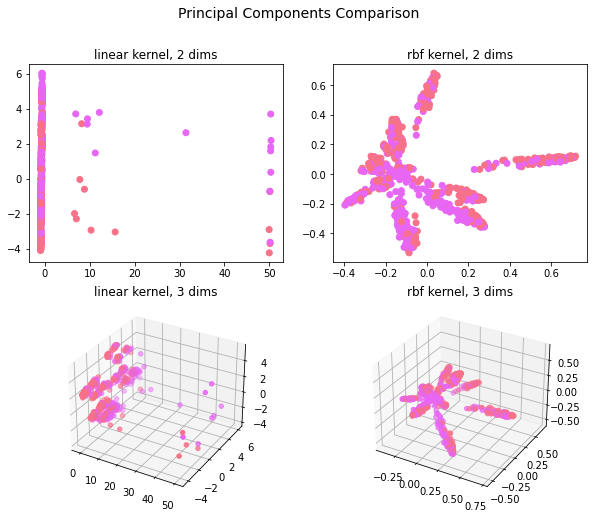

[<AxesSubplot:title={'center':'linear kernel, 2 dims'}>,
 <AxesSubplot:title={'center':'rbf kernel, 2 dims'}>,
 <Axes3DSubplot:title={'center':'linear kernel, 3 dims'}>,
 <Axes3DSubplot:title={'center':'rbf kernel, 3 dims'}>]

In [8]:
pca_comp_plot(X, y)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (863, 16) (863,)
训练集大小： (690, 16) (690,)
测试集大小： (173, 16) (173,)


In [10]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no sample weight
no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no sample weight
no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... no sample weight

 random forest [0.09401073 0.01316528 0.05408453 0.01232861 0.01657444 0.07041913
 0.09877085 0.08169506 0.13322435 0.07474812 0.08714814 0.08707646
 0.10966836 0.0499715  0.01336126 0.00375319]
done
gradient boost... no sample weight

 gradient boost [1.06514007e-01 2.95101540e-04 1.47856712e-02 5.69229171e-03
 3.65401476e-03 3.59740847e-02 7.29716180e-02 4.89545284e-02
 3.19526809e-01 3.68021403e-02 1.40222247e-01 8.97419225e-02
 9.68906459e-02 2.12413783e-02 6.73353944e-03 0.00000000e+00]
done
logistic... no sample weight
no feature importances
done
adaboost... no sample weight

 adaboost [0.15625  0.       0.015625 0.       0.015625 0.046875 0.09375  0.09375
 0.15625  0.078125 0.078125 0.0625   0.09375  0.09375  0.   

In [11]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ACC Result 0.7415983331092888 +/- 0.03925502757371207
knn ACC Result 0.6662790697674418 +/- 0.03398380668289096
naive bayes ACC Result 0.7114800376394677 +/- 0.046299293015280726
mlp ACC Result 0.6777927140744723 +/- 0.08812010806126011
random forest ACC Result 0.7636644710310525 +/- 0.06121031894053186
gradient boost ACC Result 0.7393265223820407 +/- 0.03965763573722057
logistic ACC Result 0.7393265223820407 +/- 0.05926419872471089
adaboost ACC Result 0.7370479903212798 +/- 0.09915682066990561
xgboost ACC Result 0.720782363220863 +/- 0.057932024720331196


In [12]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost
0,0.751445,0.682081,0.710983,0.676301,0.780347,0.739884,0.705202,0.780347,0.722543
1,0.722543,0.682081,0.739884,0.734104,0.728324,0.722543,0.722543,0.682081,0.664740
2,0.751445,0.635838,0.676301,0.687861,0.739884,0.716763,0.751445,0.676301,0.739884
3,0.715116,0.668605,0.697674,0.691860,0.755814,0.744186,0.726744,0.750000,0.732558
4,0.767442,0.662791,0.732558,0.598837,0.813953,0.773256,0.790698,0.796512,0.744186


In [13]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ROC AUC Result 0.8190045485278752 +/- 0.03866691406786619
knn ROC AUC Result 0.7469129940377405 +/- 0.06354599189105357
naive bayes ROC AUC Result 0.807822392279796 +/- 0.04643534587488124
mlp ROC AUC Result 0.7229972647366156 +/- 0.09885185727576015
random forest ROC AUC Result 0.8270449935460077 +/- 0.03641876067475641
gradient boost ROC AUC Result 0.8139839572192514 +/- 0.04278105972178907
logistic ROC AUC Result 0.8224746450304259 +/- 0.046939200560298884
adaboost ROC AUC Result 0.7961601819411149 +/- 0.0689066315774371
xgboost ROC AUC Result 0.7939781178929252 +/- 0.04317868534225863


In [14]:
print("Voting ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Voting ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Voting ROC-AUC score: 0.837
Voting ACC score: 0.786


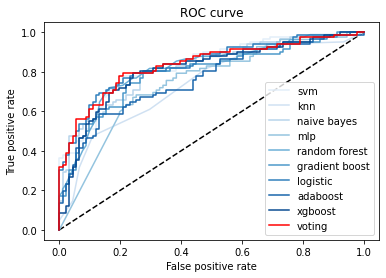

In [15]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [16]:
base_learners = get_models()

In [17]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [18]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.


{'random forest': array([0.09401073, 0.01316528, 0.05408453, 0.01232861, 0.01657444,
        0.07041913, 0.09877085, 0.08169506, 0.13322435, 0.07474812,
        0.08714814, 0.08707646, 0.10966836, 0.0499715 , 0.01336126,
        0.00375319]),
 'gradient boost': array([1.06514007e-01, 2.95101540e-04, 1.47856712e-02, 5.69229171e-03,
        3.65401476e-03, 3.59740847e-02, 7.29716180e-02, 4.89545284e-02,
        3.19526809e-01, 3.68021403e-02, 1.40222247e-01, 8.97419225e-02,
        9.68906459e-02, 2.12413783e-02, 6.73353944e-03, 0.00000000e+00]),
 'adaboost': array([0.15625 , 0.      , 0.015625, 0.      , 0.015625, 0.046875,
        0.09375 , 0.09375 , 0.15625 , 0.078125, 0.078125, 0.0625  ,
        0.09375 , 0.09375 , 0.      , 0.015625]),
 'xgboost': array([0.07291945, 0.05997357, 0.04771001, 0.04104867, 0.04177293,
        0.04587233, 0.05212701, 0.04741254, 0.17087655, 0.05548306,
        0.10976371, 0.07108281, 0.07341363, 0.05580529, 0.04539871,
        0.00933969], dtype=float32)}

In [19]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.


In [20]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=128, random_state=0,
                           subsample=0.5)

In [21]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nStacking ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Stacking ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Stacking ROC-AUC score: 0.803
Stacking ACC score: 0.757


In [22]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.835
svm ACC score: 0.786 

knn ROC-AUC score: 0.738
knn ACC score: 0.694 

naive bayes ROC-AUC score: 0.820
naive bayes ACC score: 0.740 

mlp ROC-AUC score: 0.746
mlp ACC score: 0.688 

random forest ROC-AUC score: 0.818
random forest ACC score: 0.746 

gradient boost ROC-AUC score: 0.794
gradient boost ACC score: 0.746 

logistic ROC-AUC score: 0.837
logistic ACC score: 0.775 

adaboost ROC-AUC score: 0.763
adaboost ACC score: 0.694 

xgboost ROC-AUC score: 0.811
xgboost ACC score: 0.746 



In [23]:
index = train_dataset[feature].index

## 5-fold validation

In [24]:
idx = list(index)
np.random.shuffle(idx)
X_ = X[idx]
y_ = y[idx]
cls_data_voting = train_dataset.copy().reset_index(drop=True)
cls_data_voting = cls_data_voting.iloc[idx]
cls_data_voting = cls_data_voting.reset_index(drop=True)
cv_scores_vote = []
feature_importances_list = []
prob = pd.DataFrame(columns=base_learners.keys(), dtype='float32')
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X_)):
    fold_x_train, fold_y_train = X_[train_idx, :], y_[train_idx]
    fold_x_test, fold_y_test = X_[test_idx, :], y_[test_idx]
    
    base_learners = get_models()

    feature_importances = train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    for i, model_name in zip(range(len(base_learners.keys())), base_learners.keys()):
        cls_data_voting.loc[test_idx, model_name] = P_test[:, i]
    
    p_vote = P_test.mean(axis=1)
    fold_y_pred = np.float32(p_vote > 0.5)
    
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, p_vote)
    
    cls_data_voting.loc[test_idx, 'pred'] = fold_y_pred
    cls_data_voting.loc[test_idx, 'prob'] = p_vote
    prob = pd.concat([prob, pd.DataFrame(P_test, columns=base_learners.keys())])

    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})
    feature_importances_list.append(feature_importances)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Ensemble ROC-AUC score: 0.838
Ensemble ACC score: 0.775
Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predict

In [25]:
feature_stacking = pd.DataFrame(pd.DataFrame(feature_importances_list).sum().to_dict(), index=feature)
feature_stacking['sum'] = feature_stacking.sum(axis=1)
feature_stacking = feature_stacking.sort_values(by='sum')

In [26]:
# feature_stacking.to_csv('csv/feature_importance/filled_knn_3.csv')

In [27]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.774566,0.780488,"[[70, 21], [18, 64]]",0.837979
1,0.797688,0.753247,"[[80, 16], [19, 58]]",0.863095
2,0.757225,0.688172,"[[67, 13], [29, 64]]",0.834005
3,0.767442,0.681319,"[[70, 11], [29, 62]]",0.829195
4,0.715116,0.609756,"[[73, 17], [32, 50]]",0.790244


In [28]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[360,  78],
       [127, 298]], dtype=int64)

Text(33.0, 0.5, 'True labels')

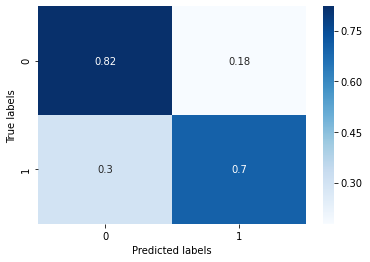

In [29]:
cm = np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [30]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost,voting
0,0.751445,0.682081,0.710983,0.676301,0.780347,0.739884,0.705202,0.780347,0.722543,0.774566
1,0.722543,0.682081,0.739884,0.734104,0.728324,0.722543,0.722543,0.682081,0.664740,0.797688
2,0.751445,0.635838,0.676301,0.687861,0.739884,0.716763,0.751445,0.676301,0.739884,0.757225
3,0.715116,0.668605,0.697674,0.691860,0.755814,0.744186,0.726744,0.750000,0.732558,0.767442
4,0.767442,0.662791,0.732558,0.598837,0.813953,0.773256,0.790698,0.796512,0.744186,0.715116


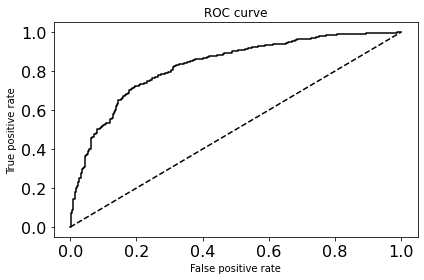

In [31]:
fpr, tpr, _ = roc_curve(cls_data_voting['severity'], cls_data_voting['prob'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Voting', c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend()
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('fig/filled_knn_6.eps',format='eps')
#plt.savefig('fig/filled_knn_6.png', format='png')

In [32]:
thres = 0.50

In [33]:
acc = accuracy_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
recall = recall_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
cm = confusion_matrix(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
roc = roc_auc_score(cls_data_voting['severity'], cls_data_voting['prob'])
sensitivity, specificity = sensitivity_specificity(cm)

print('roc auc score: \t{}'.format(roc))
print('accuarcy: \t{}'.format(acc))
print('recall: \t{}'.format(recall))
print('sensitivity: \t{}'.format(sensitivity))
print('specificity: \t{}'.format(specificity))
print('confusion matrix: \n{}'.format(cm))

roc auc score: 	0.8289497716894978
accuarcy: 	0.7624565469293163
recall: 	0.7011764705882353
sensitivity: 	0.7011764705882353
specificity: 	0.821917808219178
confusion matrix: 
[[360  78]
 [127 298]]


In [34]:
results = pd.DataFrame(index=base_learners.keys(), columns=['roc', 'acc', 'recall', 'cm', 'sensitivity', 'specificity'], dtype='object')
for k in base_learners.keys():
    acc = accuracy_score(cls_data_voting['severity'], prob[k] > thres)
    recall = recall_score(cls_data_voting['severity'], prob[k] > thres)
    cm = confusion_matrix(cls_data_voting['severity'], prob[k] > thres)
    roc = roc_auc_score(cls_data_voting['severity'], prob[k])
    sensitivity, specificity = sensitivity_specificity(cm)
    results.loc[k, :] = [roc, acc, recall, cm, sensitivity, specificity]

C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

In [35]:
# results.to_csv('./csv/cross_validation_trainSet/filled_knn_3.csv')

[Text(0.5, 0, 'Classifcation Methods'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, '5-Fold Cross Validation Accuracy')]

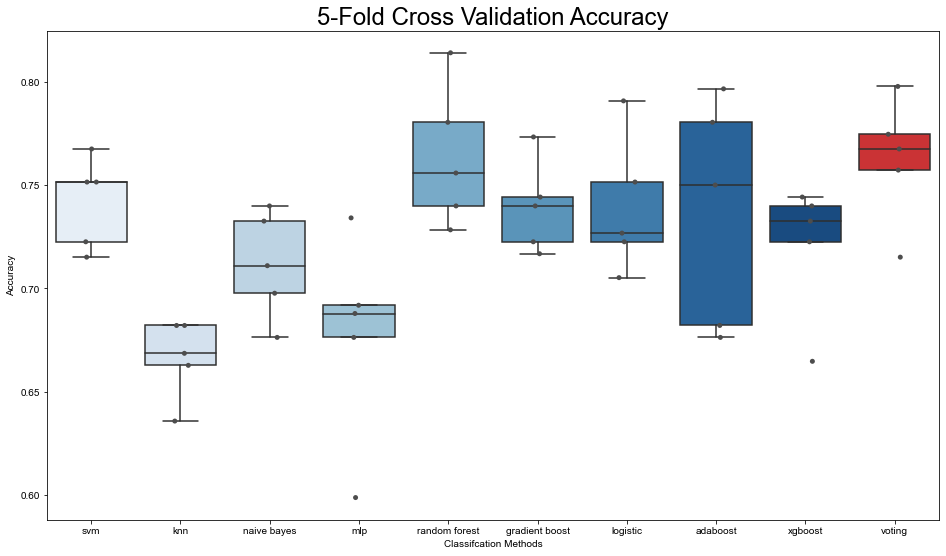

In [36]:
plt.subplots(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=2.0)
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')

In [37]:
# P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset_filled_softimpute[feature])))
# test_dataset_filled_softimpute['prediction_clinical'] = P_test.mean(axis=1)
# test_dataset_filled_softimpute.to_csv('./csv/prediction_testSet/filled_softimpute.txt')

In [38]:
# P_test = predict_base_learners(base_learners, z_score_normalize(np.array(test_dataset_filled_knn_9[feature])))
# test_dataset_filled_knn_9['prediction_clinical'] = P_test.mean(axis=1)
# test_dataset_filled_knn_9.to_csv('./csv/prediction_testSet/filled_knn_9.txt')

In [39]:
# print(X_filled_knn_3.mean(axis=0), '\n', X_filled_knn_3.std(axis=0))
# print(X_filled_knn_6.mean(axis=0), '\n',X_filled_knn_6.std(axis=0))
# print(X_filled_knn_6.mean(axis=0), '\n',X_filled_knn_6.std(axis=0))
# print(X_filled_softimpute.mean(axis=0), '\n',X_filled_softimpute.std(axis=0))